# Project 3 -- predicting cloud cover 

In [1]:
import numpy as np
import scipy.sparse as sp
np.random.seed(12)

import warnings
#Comment this to turn on warnings
warnings.filterwarnings('ignore')

from model_comparison import model_comparison
from resample import resample
import algorithms
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as n
from sklearn.linear_model import LinearRegression

from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

from utils import train_test_split

#%matplotlib notebook

In [2]:
def logit_inv(x):
    return np.exp(x)/(1+np.exp(x))

def logit(x):
    return np.log(x/(1-x))

In [11]:
def logit_inv(x): # sigmoid?
    return np.exp(x)/(1+np.exp(x))

def logit(x):
    return np.log10((x + 1e-12)/(1+1e-12-x))

# Reading in the data

In [3]:
# reading test
path = "./files/"
filenames = ["specific_humidity_Europa_sp.nc", "relative_humidity_Europa_sp.nc", "pressure_Europa_sp.nc",  
             "temperature_Europa_sp.nc", "total_cloud_cover_Europa_sp.nc"]


cloud = n.Dataset(path + filenames[-1], "r")
relative = n.Dataset(path + filenames[1], "r")
specific = n.Dataset(path + filenames[0], "r")
pressure = n.Dataset(path + filenames[2], "r")
temperature = n.Dataset(path + filenames[3], "r")

In [63]:
#print(cloud.variables)
tcc = cloud.variables["tcc"][:][:][:].data

# Retriving ground values, these are available at six different pressure levels. 
rel = relative.variables["r"][:][:][:][:].data
#level = relative.variables["level"][:][0].data
spe = specific.variables["q"][:][:][:][:].data

surf_pre = pressure.variables["sp"][:][:][:].data
temp = temperature.variables["t2m"][:][:][:].data

In [64]:
rel.shape

(32, 6, 61, 77)

In [5]:
# Choosing the number of days for training and testing.

In [81]:
# for one certain timestep 

n_days = 7

TCC = []
REL = []
SPE = []
PRE = []
TEMP = []


for t in range(n_days*4):
    TCC.append(tcc[t].flatten())
    #print(rel[t][0].flatten().shape)
    REL.append(rel[t][0].flatten())
    SPE.append(spe[t][0].flatten())
    PRE.append(surf_pre[t].flatten())
    TEMP.append(temp[t].flatten())

y = logit(np.array(TCC).flatten()) #logit(tcc[0].flatten()).reshape((4697, 1))
#x = np.array([rel[t].flatten(), spe[t].flatten(), surf_pre[t].flatten(), temp[t].flatten()]).transpose()

X = np.array([np.array(REL).flatten(),np.array(SPE).flatten(), np.array(PRE).flatten(),np.array(TEMP).flatten()])

In [82]:
y.shape

(131516,)

In [87]:
X

array([[9.67092498e+01, 9.58529196e+01, 9.56865236e+01, ...,
        4.61553261e+01, 4.42864158e+01, 4.25534631e+01],
       [7.89155626e-04, 8.08777750e-04, 8.45675872e-04, ...,
        5.33210369e-03, 5.08149505e-03, 4.94456676e-03],
       [1.00881369e+05, 1.00877530e+05, 1.00848736e+05, ...,
        9.41923288e+04, 9.51490578e+04, 9.62528281e+04],
       [2.54531033e+02, 2.55042680e+02, 2.56260888e+02, ...,
        2.88493727e+02, 2.88662402e+02, 2.88954772e+02]])

In [88]:
X = X.transpose()

In [89]:
X

array([[9.67092498e+01, 7.89155626e-04, 1.00881369e+05, 2.54531033e+02],
       [9.58529196e+01, 8.08777750e-04, 1.00877530e+05, 2.55042680e+02],
       [9.56865236e+01, 8.45675872e-04, 1.00848736e+05, 2.56260888e+02],
       ...,
       [4.61553261e+01, 5.33210369e-03, 9.41923288e+04, 2.88493727e+02],
       [4.42864158e+01, 5.08149505e-03, 9.51490578e+04, 2.88662402e+02],
       [4.25534631e+01, 4.94456676e-03, 9.62528281e+04, 2.88954772e+02]])


# Regression analysis 

In [90]:
# Experimental setup
models = {
    "ols": algorithms.OLS,
    #"ols": LinearRegression,
    'ridge': algorithms.Ridge, 
    "lasso": algorithms.Lasso
}
param_grid = {
    'ols': [0],
    'ridge': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100, 10**3, 10**4, 10**5],  
    'lasso': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100, 10**3, 10**4, 10**5]
}

# Choosing the same splitsize as the notebook in order to compare. 
results, z_pred_best, coeffs = model_comparison(
    models, param_grid, X, y, split_size=0.2
    )

Testing model: ols
Testing model: ridge
Testing model: lasso
0


In [91]:
results.keys()

dict_keys(['mse_test', 'mse_train', 'r2_test', 'r2_train'])

In [92]:
results["r2_test"]["ridge"]

[[0.18840118870397604,
  0.18839769280063556,
  0.18835841484255544,
  0.18775024902427773,
  0.18414492651806824,
  0.18195861441803762,
  0.18164407106985347,
  0.1816112698432255,
  0.18160783919772683,
  0.18160328884584986]]

In [93]:
results["r2_test"]["ols"]

[[0.1939710734618687]]

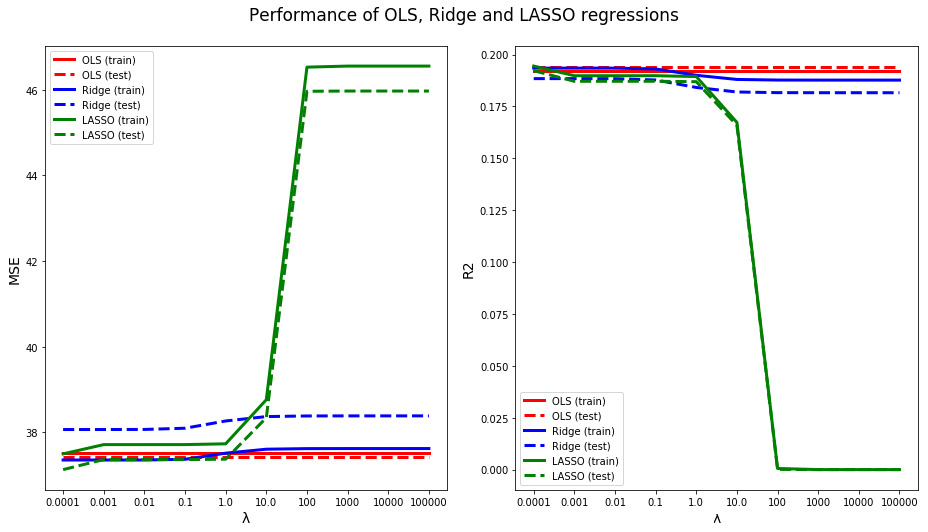

In [95]:
# Generate figure

# MSE
plt.figure(1, figsize = (13,7))
plt.subplot(1,2,1)
xlogr = np.log10(param_grid['ridge'])  # log x-axis
plt.plot(xlogr, (results["mse_train"]["ols"]*np.ones(len(xlogr))).T, 'r', label='OLS (train)', linewidth=3.0) 
plt.plot(xlogr, (results["mse_test"]["ols"]*np.ones(len(xlogr))).T, 'r--', label='OLS (test)',  linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_train"]["ridge"]).T, 'b', label='Ridge (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_test"]["ridge"]).T, 'b--', label='Ridge (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_train"]["lasso"]).T, 'g', label='LASSO (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_test"]["lasso"]).T, 'g--', label='LASSO (test)', linewidth=3.0) 
ax = plt.gca()
plt.xticks(np.asarray(xlogr))
ax.set_xticklabels(param_grid['ridge'])
plt.xlabel('λ', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.legend()

# R-squared
plt.subplot(1,2,2)
plt.plot(xlogr, (results["r2_train"]["ols"]*np.ones(len(xlogr))).T, 'r', label='OLS (train)', linewidth=3.0) 
plt.plot(xlogr, (results["r2_test"]["ols"]*np.ones(len(xlogr))).T, 'r--', label='OLS (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_train"]["ridge"]).T, 'b', label='Ridge (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_test"]["ridge"]).T, 'b--', label='Ridge (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_train"]["lasso"]).T, 'g', label='LASSO (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_test"]["lasso"]).T, 'g--', label='LASSO (test)', linewidth=3.0) 
ax = plt.gca()
plt.xticks(np.asarray(xlogr))
ax.set_xticklabels(param_grid['ridge'])
plt.xlabel('λ', fontsize=14)
plt.ylabel('R2', fontsize=14)
plt.legend()
plt.suptitle("Performance of OLS, Ridge and LASSO regressions", y=1.05, fontsize=17)
plt.savefig("results/figures/metric_regression_on_allData.png", bbox_inches = "tight")
plt.tight_layout()    
plt.show()

# Determining which feature is most important

## Results:

# Bias and variance discussion 

In [20]:
# Experimental setup
models = {
    "ols": algorithms.OLS, 
    "ridge": algorithms.Ridge, 
    "lasso": algorithms.Lasso, 
}

lmd = {
    'ols': [0],
    'lasso': [0.001],
    'ridge':[0.001]
    
}
nboots = 100

z_test, z_pred_test, bias, var, beta, mse_test, mse_train, ci_beta = resample(models, lmd, X, y, nboots, split_size = 0.2)

ci_beta.shape

(2, 4)

In [21]:
ci_beta.shape # Muligens ikke så mys vits med konfidenseintervall av disse dimensjoner. 

(2, 4)

In [22]:
bias

{'ridge': 35.65100253983485,
 'lasso': 35.63489771931126,
 'ols': 35.665151208410094}

In [23]:
var # variance dominates because we don't have so mush data???

{'ridge': 0.03382487692766836,
 'lasso': 0.034644139172044126,
 'ols': 0.033078603263385596}

In [24]:
mse_test

{'ridge': 35.684827416762516,
 'lasso': 35.66954185848331,
 'ols': 35.698229811673485}

In [25]:
bias["ols"] + var["ols"] 

35.69822981167348

In [26]:
bias["ridge"] + var["ridge"] 

35.684827416762516

In [27]:
bias["lasso"] + var["lasso"] 

35.669541858483306

The bias and variance summes to the mse of the ols model.

In [32]:
#logit_inv(z_pred_best["lasso"])

# Compare with scikit learn

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, split_size=0.5)

In [99]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
model.predict(X_test)
model.score(X_test, y_test) #returns the r2 score

0.19253829525012356

In [103]:
model.coef_

array([ 2.16430866e-01, -7.58199969e+02,  1.51507063e-05,  9.66195837e-02])

In [ ]:
# relative humidity, specific humidity, pressure, temprature